In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm
import scipy.stats as scistats
import scipy.io as io
import scipy.integrate as sciint
import scipy.optimize as sciopt
import scipy.interpolate as sciinter
import time

# Problem 1

Consider the following model
\begin{equation}
x_n = \theta  + \epsilon_n,
\end{equation}
where $\epsilon_n \sim \mathcal{N}(0, \sigma^2)$. The measured data, given in the file __a2_data1.mat__, will be modelled with the aforementioned model. The appropriate data has a dictionary key: 'x'.

## Part A: Grid-based Bayesian inference

Assume that $\sigma$ is known and given by $\sigma = 1.5$. Assume a Laplacian prior for $\theta$ with the following form:
\begin{equation}
 p(\theta) = L(\theta \vert 0, 2),
\end{equation}    
where 0 is the location parameter and 2 is the scaling parameter. Use a grid between -10 and 20 to answer all subsequent questions. 


### Load in the data

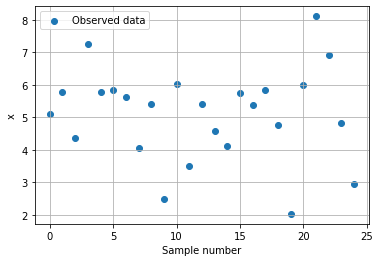

In [40]:
Q1_mat = io.loadmat(r"G:\My Drive\Engineering\PhD\2022\MIL780\Block 2\Assignment\a2_data1.mat")
Q1_data = Q1_mat['x'][0, :]
sigma = 1.5
theta_range = np.linspace(-10, 20, 1000)

plt.figure()
plt.scatter(np.arange(len(Q1_data)), Q1_data, label = "Observed data")
plt.legend()
plt.ylabel("x")
plt.xlabel("Sample number")
plt.grid()
plt.savefig("./images/Q1a_1.pdf")
plt.show()

### Q1a) Plot the prior over $\theta$

The prior over $\theta$ is given analytically as
\begin{equation}
p(\theta) = L(\mu, b) = \frac{1}{2b} e^{-\frac{\vert x - \mu \vert}{b}},
\end{equation}

and the logarithm of this distribution is equal to
\begin{equation}
\log p(\theta) = -\log ( 2\cdot b ) - \frac{\vert x - \mu \vert}{b}
\end{equation}

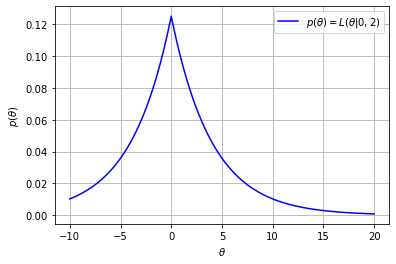

In [43]:
def laplace_likelihood(x, mu, b):
    
    p1 = 1 / (2 * b)
    p2 = np.exp( - np.abs(x - mu) / b)
    return p1 * p2

def laplace_log_likelihood(x, mu, b):
    
    p1 = - np.log(2 * b)
    p2 = - np.abs(x - mu) / b
    return p1 + p2

#prior = scistats.laplace(0, 2)
plt.figure()
plt.plot(theta_range, laplace_likelihood(theta_range, 0, 4), color = "b", label = r"$p(\theta) = L(\theta \vert 0, 2)$")
plt.xlabel(r"$\theta$")
plt.ylabel(r"$p(\theta)$")
plt.legend()
plt.grid()
plt.savefig("./images/Q1a_2.pdf")
plt.show()

### Q1b) Calculate and plot the likelihood function over $\theta$

Given the following model, the distribution over x is given as
\begin{equation}
\begin{aligned}[b]
p(x \vert \theta) &= \mathcal{N}(x \vert \theta, \sigma^2) \\
&= \frac{1}{\sqrt{2 \cdot \pi \cdot \sigma^2}} e^{-\frac{1}{2\sigma^2} \cdot \left( x - \theta \right)^2}.
\end{aligned}
\end{equation}

Given some observed data $\mathbf{x}$, where $\mathbf{x}$ is a column vector $\mathbf{x} \in \mathbb{R}^{N \times 1}$ and $N$ is the number of observed samples, the likelihood function, given $\theta$, is
\begin{equation}
\mathcal{L}(\mathbf{x}, \theta) = \prod_{n=1}^{N} p(x_n \vert \theta).
\end{equation}

The log-likelihood function may be given as
\begin{equation}
\begin{aligned}
\mathcal{LL}(\mathbf{x}, \theta) &= \sum_{n=1}^{N} \log p(x_n \vert \theta) \\
&= \sum_{n=1}^{N} \left[ -\frac{1}{2}\log (2\cdot \pi) - \frac{1}{2}\log (\sigma^2) - \frac{\left( x - \theta \right)^2}{2\sigma^2} \right] \\
&= -\frac{N}{2}\log (2\cdot \pi) - \frac{N}{2}\log (\sigma^2) - \sum_{n=1}^{N} \left[\frac{\left( x - \theta \right)^2}{2\sigma^2} \right].
\end{aligned}
\end{equation}

It is important here to remind ourselves (read: myself) of the functions of the $\mathcal{LL}$ function. The observed data is typically fixed, and thus the only variable that we can alter is $\theta$. Thus, we can plot how the likelihood/log-likelihood function varies with $\theta$.

C:\Users\RYANB~1.LAP\AppData\Local\Temp/ipykernel_13308/386081039.py:30: RuntimeWarning: divide by zero encountered in log
  ax[1].plot(theta_range, np.log(likelihood_total), label = 'likelihood function (pdf evaluation)')


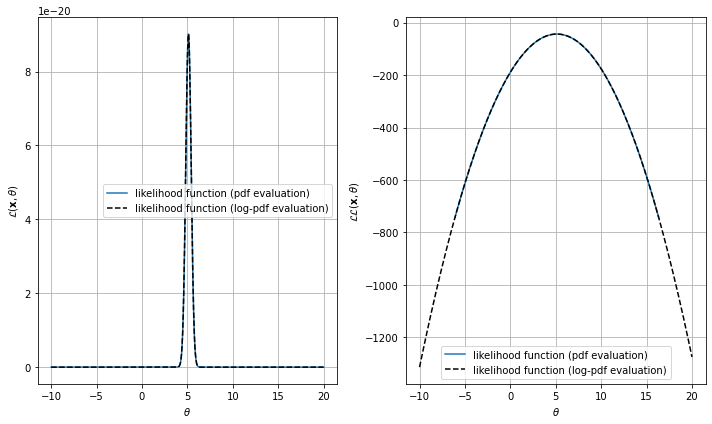

In [26]:
def gaussian_likelihood(x, mu, sigma):
    p1 =1/(np.sqrt(2 * np.pi * sigma**2))
    p2 = np.exp(- 1/(2 * sigma**2) * (x - mu)**2)
    return  p1 * p2

def gaussian_log_likelihood(x, mu, sigma):
    p1 = - 1/2 * np.log(2 * np.pi)
    p2 = - 1/2 * np.log(sigma**2)
    p3 = - 1/(2 * sigma**2) * (x - mu)**2
    return p1 + p2 + p3

N = len(Q1_data)
likelihoods = np.zeros((len(theta_range), N))
log_likelihoods = np.zeros((len(theta_range), N))

for cnt, i in enumerate(theta_range):
    likelihoods[cnt, :] = gaussian_likelihood(Q1_data, i, sigma)
    log_likelihoods[cnt, :] = gaussian_log_likelihood(Q1_data, i, sigma)
    
likelihood_total = np.product(likelihoods, axis = 1)
log_likelihood_total = np.sum(log_likelihoods, axis = 1)

fig, ax = plt.subplots(1, 2, figsize = (10, 6))
ax = ax.flatten()

ax[0].plot(theta_range, likelihood_total, label = 'likelihood function (pdf evaluation)')
ax[0].plot(theta_range, np.exp(log_likelihood_total), "k--", label = 'likelihood function (log-pdf evaluation)')
ax[0].set_ylabel(r"$\mathcal{L}(\mathbf{x}, \theta)$")

ax[1].plot(theta_range, np.log(likelihood_total), label = 'likelihood function (pdf evaluation)')
ax[1].plot(theta_range, log_likelihood_total, "k--", label = 'likelihood function (log-pdf evaluation)')
ax[1].set_ylabel(r"$\mathcal{LL}(\mathbf{x}, \theta)$")
for axs in ax:
    axs.set_xlabel(r"$\theta$")
    axs.grid()
    axs.legend()
    
fig.tight_layout()
plt.savefig("./images/Q1a_3.pdf")
plt.show()

### Q1c) Calculate and plot the unnormalised posterior function over $\theta$.

The unnormalised posterior is the numerator of posterior distribution over $\theta$ given $\mathbf{x}$. This is given through Bayes' rule
\begin{equation}
p(\theta \vert \mathbf{x}) = \frac{p(\mathbf{x}\vert\theta)p(\theta)}{p(\mathbf{x})}.
\end{equation}

It is now clear why the prior was the first step of the process. We assume a prior over $\theta$, observe some data $\mathbf{x}$ and then we can inspect the posterior $p(\theta \vert \mathbf{x})$. To do this, we need the unnormalised posterior $p(\mathbf{x}\vert\theta)p(\theta)$ and the model evidence $p(\mathbf{x})$. So. let's plot the un-normalised posterior! To do so, let us write the form of this posterior, which we can do as we have assumed analytical forms of the model distribution and the prior distribution. Interestingly, we can also refer to the unnormalised posterior as the joint distribution over $\mathbf{x}$ and $\theta$.
\begin{equation}
\begin{aligned}
p(\mathbf{x}, \theta) &= p(\mathbf{x}\vert\theta)p(\theta) \\
\mathcal{F}(\theta, \mathbf{x}, , \sigma, \mu_\theta, b) &= \frac{1}{2 \cdot b} \exp{ \left(- \frac{\vert \theta - \mu_\theta \vert}{b} \right)} \prod_{n=1}^{N} \frac{1}{ \sqrt{2 \cdot \pi \cdot \sigma^2}} \exp{ \left(-\frac{1}{2\sigma^2} \cdot \left( x_n - \theta \right)^2 \right)},
\end{aligned}
\end{equation}
where $\mathcal{F}(\theta, \mathbf{x}, \sigma, \mu_\theta, b)$ is the notation that I have adopted to show the parameters of the joint term. In this case, $\sigma$, $\mu_\theta$ an $b$ are fixed to $\sigma =1.5$,  $\mu_\theta = 0$ and $b = 2$. It is also possible to inspect the log-unnormalised posterior, and this is given analytically as
\begin{equation}
\begin{aligned}
\log p(\mathbf{x}, \theta) &= \log p(\mathbf{x}\vert\theta) + \log p(\theta) \\
&= \sum_{n=1}^{N} \left[ -\frac{1}{2}\cdot\log (2\cdot \pi) - \frac{1}{2}\cdot\log (\sigma^2) - \frac{\left( x_n - \theta \right)^2}{2\sigma^2} \right]  -\log ( 2\cdot b ) - \frac{\vert \theta - \mu_\theta \vert}{b} \\ 
&= -\frac{N}{2} \cdot \log (2\cdot \pi) - \frac{N}{2} \cdot \log (\sigma^2) - \log ( 2\cdot b ) - \frac{\vert \theta - \mu_\theta \vert}{b} - \sum_{n=1}^{N} \frac{\left( x_n - \theta \right)^2}{2\sigma^2}.
\end{aligned}
\end{equation}

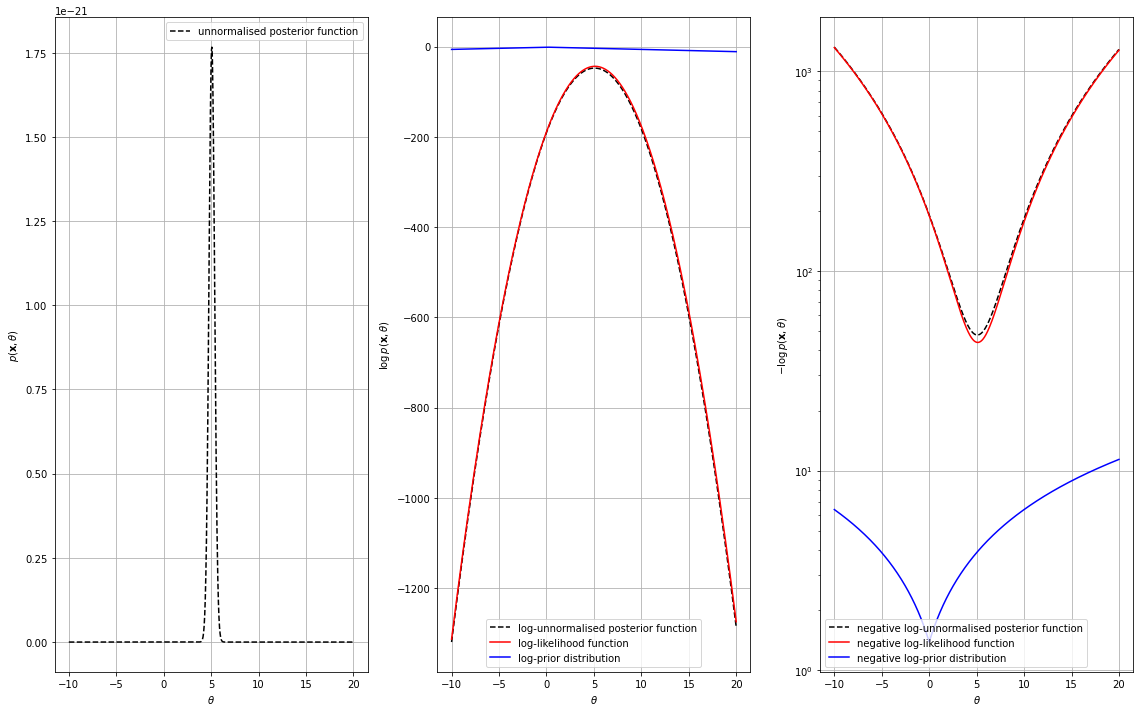

In [46]:
def unnormalised_posterior_function(theta, x, sigma, mu_p, scale_p):
    #mu_g, sigma_g = generative (modelled) distribution parameter tuple
    #mu_p, sigma_p = prior distribution parameter tuple
    p_x_G_theta = np.product(gaussian_likelihood(x, theta, sigma))
    p_theta = laplace_likelihood(theta, mu_p, scale_p)
    
    return p_x_G_theta * p_theta

def unnormalised_log_posterior_function(theta, x, sigma, mu_p, scale_p):
    #mu_g, sigma_g = generative (modelled) distribution parameter tuple
    #mu_p, sigma_p = prior distribution parameter tuple
    log_p_x_G_theta = np.sum(gaussian_log_likelihood(x, theta, sigma))
    log_p_theta = laplace_log_likelihood(theta, mu_p, scale_p)
    
    return log_p_x_G_theta + log_p_theta

def trial_function(theta, x, sigma, mu_p, scale_p):
    N = len(x)
    p1 = -N/2 * np.log(2 * np.pi)
    p2 = -N/2 * np.log(sigma**2)
    p3 = -np.log(2 * scale_p)
    p4 = -np.abs(model_params[0] - mu_p) / scale_p
    p5 = -1 * np.sum((x - theta)**2 / (2 * sigma**2))
    
    return p1 + p2 + p3 + p4 + p5

N = len(Q1_data)
unorm_post = np.zeros(len(theta_range))
log_unorm_post = np.zeros(len(theta_range))
t = np.zeros(len(theta_range))

for cnt, i in enumerate(theta_range):
    model_params = (i, sigma)
    unorm_post[cnt] = unnormalised_posterior_function(i, Q1_data, sigma, 0, 2)
    log_unorm_post[cnt] = unnormalised_log_posterior_function(i, Q1_data, sigma, 0, 2)
    t[cnt] = trial_function(i, Q1_data, sigma, 0, 2)

fig, ax = plt.subplots(1, 3, figsize = (16, 10))
ax = ax.flatten()

ax[0].plot(theta_range, unorm_post, "k--", label = "unnormalised posterior function")
ax[0].set_ylabel(r"$p(\mathbf{x}, \theta)$")

ax[1].plot(theta_range, log_unorm_post, "k--", label = 'log-unnormalised posterior function')
ax[1].plot(theta_range, log_likelihood_total, "r", label = "log-likelihood function")
ax[1].plot(theta_range, laplace_log_likelihood(theta_range, 0, 2), "b", label = "log-prior distribution")
#ax[0].plot(theta_range, t, "c-.") #used to test the functions
ax[1].set_ylabel(r"$\log p(\mathbf{x}, \theta)$")

#ax[1].plot(theta_range, np.log(unorm_post_total), label = 'unnormalised posterior function (pdfs)')
ax[2].semilogy(theta_range, -1 * log_unorm_post, "k--", label = 'negative log-unnormalised posterior function')
ax[2].plot(theta_range, -1 * log_likelihood_total, "r", label = "negative log-likelihood function")
ax[2].plot(theta_range, -1 * laplace_log_likelihood(theta_range, 0, 2), "b", label = "negative log-prior distribution")
#ax[1].plot(theta_range, -1 * t, "c-.")  #used to test the functions
ax[2].set_ylabel(r"$-\log p(\mathbf{x}, \theta)$")
for axs in ax:
    axs.set_xlabel(r"$\theta$")
    axs.grid()
    axs.legend()
    
fig.tight_layout()
plt.savefig("./images/Q1a_4.pdf")
plt.show()

### Q1d) Calculate the natural logarithm of the model evidence.

The model evidence, otherwise referred to as the marginal likelihood, is given as
\begin{equation}
\begin{aligned}
p(\mathbf{x}) &= \int_\theta p(\mathbf{x}, \theta) d\theta \\
&= \int_\theta p(\mathbf{x} \vert \theta) p(\theta) d\theta \\
&= 1.32856e^{-21} \\
\end{aligned}
\end{equation}

I will not attempt to solve this analytically, I will use scipy.integrate functions such as __quad__ or __trapz__.

In [16]:
model_evidence, error = sciint.quad(unnormalised_posterior_function, np.min(theta_range), np.max(theta_range), args = (Q1_data, sigma, 0, 2))
print(sciint.trapz(unorm_post, theta_range))
print(model_evidence)

1.3285396736427778e-21
1.3285608392025405e-21


### Q1e Plot the posterior distribution

The posterior distribution is obtained using Bayes' rule. Now that we know all of the terms (un-normalised posterior and the model evidence), we can easily calculate this term!

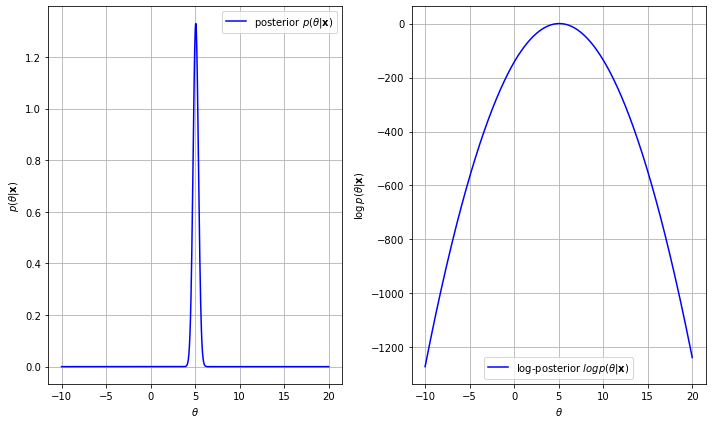

In [17]:
def posterior_function(theta, x, sigma, mu_p, scale_p):
    
    unnormalised_posterior = unnormalised_posterior_function(theta, x, sigma, mu_p, scale_p)
    evidence, _ = sciint.quad(unnormalised_posterior_function, np.min(theta_range), np.max(theta_range), args = (x, sigma, mu_p, scale_p))
    
    return unnormalised_posterior / evidence

def log_posterior_function(theta, x, sigma, mu_p, scale_p):
    
    log_unnormalised_posterior = unnormalised_log_posterior_function(theta, x, sigma, mu_p, scale_p)
    evidence, _ = sciint.quad(unnormalised_posterior_function, np.min(theta_range), np.max(theta_range), args = (x, sigma, mu_p, scale_p))
    
    return log_unnormalised_posterior - np.log(evidence)

posterior = np.zeros(len(theta_range))
log_posterior = np.zeros(len(theta_range))

#This works, you can check the results if you want
posterior_check = unorm_post / model_evidence
log_posterior_check = log_unorm_post - np.log(model_evidence)

for cnt, i in enumerate(theta_range):
    posterior[cnt] = posterior_function(i, Q1_data, sigma, 0, 2)
    log_posterior[cnt] = log_posterior_function(i, Q1_data, sigma, 0, 2)

fig, ax = plt.subplots(1, 2, figsize = (10, 6))
ax = ax.flatten()

ax[0].plot(theta_range, posterior, "b-", label = r"posterior $p(\theta \vert \mathbf{x})$")
#ax[0].plot(theta_range, posterior_check, "r--") #turn these off for now
ax[0].set_ylabel(r"$p(\theta \vert \mathbf{x})$")

ax[1].plot(theta_range, log_posterior, "b-", label = r"log-posterior $log p(\theta \vert \mathbf{x})$")
#ax[1].plot(theta_range, log_posterior_check, "r--") #turn these off for now
ax[1].set_ylabel(r"$\log p(\theta \vert \mathbf{x})$")

for axs in ax:
    axs.set_xlabel(r"$\theta$")
    axs.legend()
    axs.grid()
fig.tight_layout()
plt.savefig("./images/Q1a_5.pdf")
plt.show()

### Q1f) Plot the posterior predictive distribution

The posterior predictive distribution is given as
\begin{equation}
p(x\vert \mathbf{x}) = \int_\theta p(x \vert \theta) p(\theta \vert \mathbf{x}) d\theta
\end{equation}

202.1539590358734 seconds for expensive evaluation
0.03904223442077637 seconds for cheap evaluation


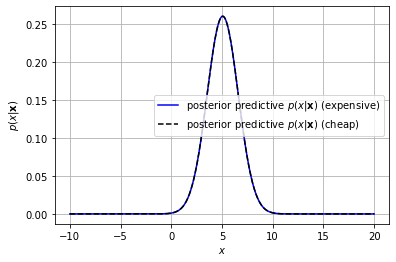

In [18]:
def posterior_predictive_function(theta, x, X, sigma, mu_p, scale_p): #expensive evaluation
    
    model_likelihood = gaussian_likelihood(x, theta, sigma)
    posterior = posterior_function(theta, X, sigma, mu_p, scale_p)
    
    
    return model_likelihood * posterior

def posterior_predictive_cheap(theta_range, x, X, sigma, mu_p, scale_p, posterior): #cheap evaluation, use posterior you already have
    
    model_likelihood = gaussian_likelihood(x, theta_range, sigma)
    
    
    return model_likelihood * posterior

x_range = theta_range
posterior_predictive_likelihood = np.zeros(len(x_range))
posterior_predictive_likelihood_cheap = np.zeros(len(x_range))
t0 = time.time()
for cnt, i in enumerate(x_range):
    
    #expensive
    posterior_predictive_likelihood[cnt], _ = sciint.quad(posterior_predictive_function, 
                                                          np.min(theta_range), 
                                                          np.max(theta_range), 
                                                         args = (i, Q1_data, sigma, 0, 2))

print(time.time() - t0, "seconds for expensive evaluation")

t0 = time.time()
for cnt, i in enumerate(x_range):
    
    #cheap    
    posterior_predictive_likelihood_cheap[cnt] = sciint.trapz(posterior_predictive_cheap(theta_range, 
                                                                                         i, 
                                                                                         Q1_data, 
                                                                                         sigma, 
                                                                                         0, 
                                                                                         2, 
                                                                                         posterior),
                                                             theta_range)

print(time.time() - t0, "seconds for cheap evaluation")

plt.figure()
plt.plot(x_range,  posterior_predictive_likelihood, "b-", label = r"posterior predictive $p(x \vert \mathbf{x})$ (expensive)")
plt.plot(x_range,  posterior_predictive_likelihood_cheap, "k--", label = r"posterior predictive $p(x \vert \mathbf{x})$ (cheap)")
plt.xlabel("$x$")
plt.ylabel(r"$p(x \vert \mathbf{x})$")
plt.legend()
plt.grid()
plt.savefig("./images/Q1a_6.pdf")
plt.show()
    

### Q1g) Calculate and compare the maximum prior, maximum likelihood and maximum a posteriori estimates of the unknown parameter.

To determine the maximum, we can find the maximum in the following ways:
- analytically
- grid-based
- numerical optimisation-based

To begin, let's consider the analytical solution for the 

#### Grid-based approach

In [27]:
#Prior
pos_prior = np.argmax(laplace_likelihood(theta_range, 0, 2))
print("Prior: {}".format(theta_range[pos_prior]))

#Maximum likelihood
pos_ML = np.argmax(log_likelihood_total)
print("ML solution: {}".format(theta_range[pos_ML]))

#MAP 
pos_MAP = np.argmax(log_unorm_post)
print("MAP solution: {}".format(theta_range[pos_MAP]))

Prior: 0.0
ML solution: 5.105105105105105
MAP solution: 5.075075075075075


#### Analytical solution

For the prior, we can sample the prior to estimate the mean using Monte Carlo integration . Specically, we want to estimate $\mathbb{E}_{\theta \sim p(\theta)}\{ x \}$.

For the ML solution, we can maximise the log-likelihood function for the observed. By deriving Equation [EQ] with respect to the unknown parameter, $\theta$, we set the derivative equal to zero to obtain an analytical root, and arrive at
\begin{equation}
\hat{\theta}_{ML} = \frac{1}{N} \sum_{n=1}^{N} x_n.
\end{equation}

For the MAP solution, we cannot determine the optimal parameters analytically as there is no analytical solution to the log-likelihood function derivative root. 

In [28]:
#Prior:
prior = scistats.laplace(0, 2)
prior_samples = prior.rvs(100000)
print("Prior: {}".format(np.mean(prior_samples)))

#ML solution:
print("ML solution: {}".format(np.mean(Q1_data)))

#MAP solution:
print("MAP solution: Cannot be determined due to Laplace distribution prior")

Prior: -0.002004405098700601
ML solution: 5.116094896529196
MAP solution: Cannot be determined due to Laplace distribution prior


#### Numerical optimisation solution 

Here we will use scipy.optimize.minimize to obtain the optimal parameters. For the prior, we will need to sample the prior a couple of times.

For the MAP solution, we use the unnormalised log-posterior distribution.

In [29]:
#Prior
prior_samples = prior.rvs(100000)
prior_opt = lambda mu: -1 * np.sum(laplace_log_likelihood(prior_samples, mu, 2))
results_prior = sciopt.minimize_scalar(prior_opt)

print("Prior: {}".format(results_prior['x']))

#ML solution:
ML_opt = lambda mu: -1 * np.sum(gaussian_log_likelihood(Q1_data, mu, sigma))
results_ML = sciopt.minimize_scalar(ML_opt)
print("ML solution: {}".format(results_ML['x']))

#MAP solution:
MAP_opt = lambda mu, x, sigma, mu_p, scale_p: -1 * np.sum(unnormalised_log_posterior_function(mu, x, sigma, mu_p, scale_p))
results_MAP = sciopt.minimize_scalar(MAP_opt, args = (Q1_data, sigma, 0, 2))
print("MAP solution: {}".format(results_MAP['x']))

Prior: -0.002736616564345116
ML solution: 5.116094896529205
MAP solution: 5.071094896529205


### Q1h) Calculate and compare the following two quantities: $p(\theta \leq 4 \vert \mathbf{x})$ and $p(x \leq 4 \vert \mathbf{x})$. Briefly discuss the differences between the two quantities and how they should be used in the inference process.

Note:  $p(\theta \leq 4 \vert x)$ uses the posterior distribution $p(\theta \vert \mathbf{x})$ while $p(x \leq 4 \vert x)$ uses the posterior predictive distribution. We can estimate these terms using an approximate CDF for the distibutions. We obtain this approximate CDF by using scipy.integrate.cumtrapz to approximate the integral. We can use linear interpolation to evaluate the probabilities of interest.

Remember:

\begin{equation}
p(a \leq x \leq b) = F_x(b) - F_x(a),
\end{equation}
where $F_x(X) = \int_{-\infty}^{X} p(x) dx$ is the CDF of $p(x)$.

0.0001823995269009567 0.24191214204274583


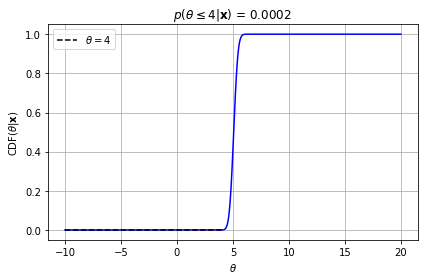

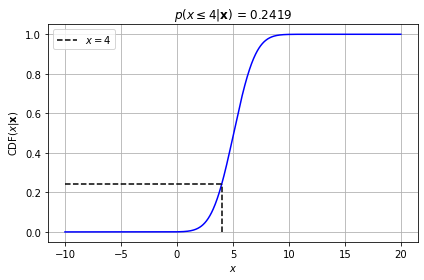

In [34]:
CDF_approx_posterior = sciint.cumulative_trapezoid(posterior, theta_range, initial = 0)
CDF_approx_posterior_predict = sciint.cumulative_trapezoid(posterior_predictive_likelihood, theta_range, initial = 0)

#Fit linear interpolation model
CDF_post_LI = sciinter.interp1d(theta_range, CDF_approx_posterior)
CDF_post_pred_LI = sciinter.interp1d(x_range, CDF_approx_posterior_predict)

prob_1 = CDF_post_LI(4)
prob_2 = CDF_post_pred_LI(4)
print(prob_1, prob_2)

fig, ax = plt.subplots(1, 1)

ax.plot(theta_range, CDF_approx_posterior, color = "b")
ax.plot([4, 4], [0, prob_1], "k--")
ax.plot([np.min(theta_range), 4], [prob_1, prob_1], "k--", label = r"$\theta = 4$")
ax.set_xlabel(r"$\theta$")
ax.set_ylabel(r"CDF($\theta \vert \mathbf{x}$)")
ax.set_title(r"$p(\theta \leq 4 \vert \mathbf{})$ = {:.4f}".format("{" + "x" + "}", prob_1))

ax.grid()
ax.legend()

fig.tight_layout()
plt.savefig("./images/Q1a_7a.pdf")
plt.show()

fig, ax = plt.subplots(1, 1)

ax.plot(theta_range, CDF_approx_posterior_predict, color = "b")
ax.plot([4, 4], [0, prob_2], "k--")
ax.plot([np.min(x_range), 4], [prob_2, prob_2], "k--", label = r"$x = 4$")
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"CDF($x \vert \mathbf{x}$)")
ax.set_title(r"$p(x \leq 4 \vert \mathbf{})$ = {:.4f}".format("{" + "x" + "}", prob_2))

ax.grid()
ax.legend()

fig.tight_layout()
plt.savefig("./images/Q1a_7b.pdf")
plt.show()

### Q1i) 

The prior is parameterised as: 
\begin{equation}
p(\theta; \alpha) = L(\theta \vert 0, \alpha)
\end{equation}
where $\alpha$ is a hyper-parameter. How does the prior parameter affect the parameter estimates (e.g. MAP) and how does it affec the model evidence? Please make sure that your grid covers the domain of $p(\theta; \alpha)$.

In [35]:
alpha_range = np.linspace(0.1, 4, 100)
theta_range = np.linspace(-20, 20, 1000)

#MAP optimal
MAP_estimates = []
evidence_estimates = []

for cnt, alpha in enumerate(alpha_range):
    
    MAP_opt = lambda mu, x, sigma, mu_p, scale_p: -1 * np.sum(unnormalised_log_posterior_function(mu, x, sigma, mu_p, scale_p))
    results_MAP = sciopt.minimize_scalar(MAP_opt, args = (Q1_data, sigma, 0, alpha))
    MAP_estimates.append(results_MAP['x'])
    
    model_evidence, error = sciint.quad(unnormalised_posterior_function, np.min(theta_range), np.max(theta_range), args = (Q1_data, sigma, 0, alpha))
    evidence_estimates.append(model_evidence)
    
plot_posteriors = []
for cnt, alpha in enumerate(alpha_range):
    
    posterior = []
    
    for i in theta_range:
        posterior.append(posterior_function(i, Q1_data, sigma, 0, alpha))
    
    plot_posteriors.append(posterior)

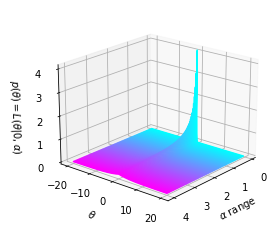

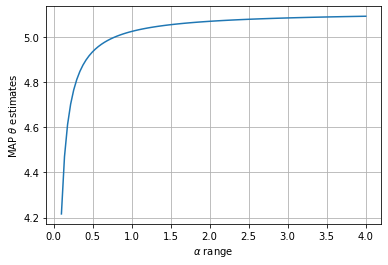

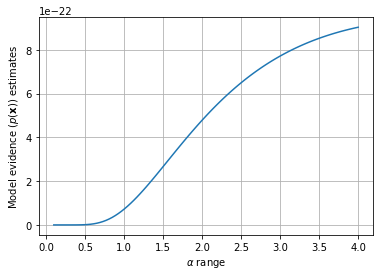

(250, 100) (250, 100) (100, 250)


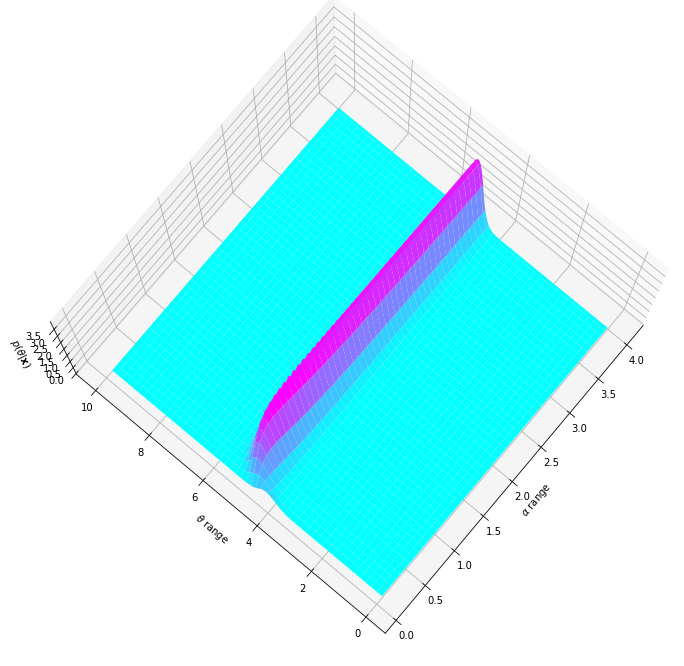

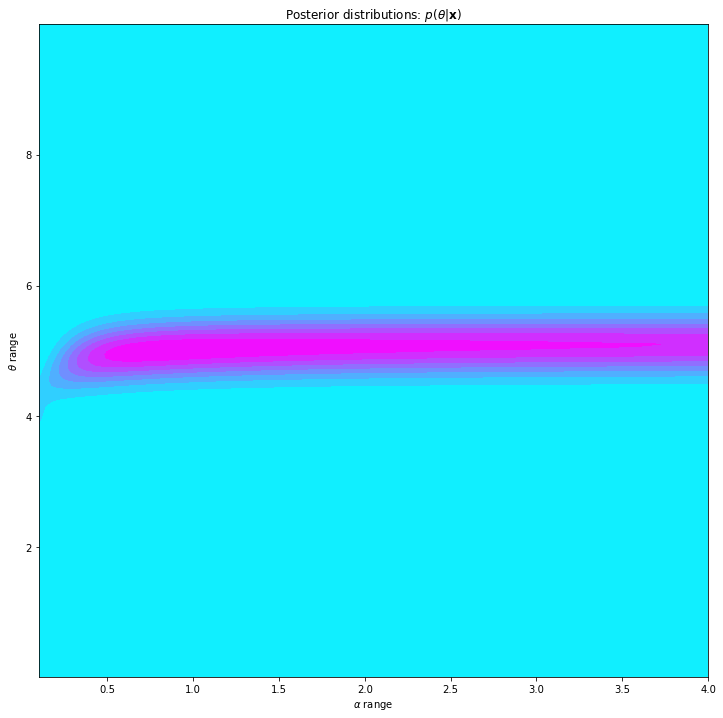

In [38]:
%matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(projection = '3d')
colors = plt.cm.cool(np.linspace(0, 1, len(alpha_range)))

for cnt, alpha in enumerate(alpha_range):
    ax.plot([alpha] * len(theta_range), theta_range, laplace_likelihood(theta_range, 0, alpha), color = colors[cnt])
ax.set_xlabel(r"$\alpha$ range")
ax.set_ylabel(r"$\theta$")
ax.set_zlabel(r"$p(\theta) = L(\theta \vert 0, \alpha)$")
ax.grid()
ax.view_init(elev=20, azim=40)
plt.savefig("./images/Q1a_8.pdf")
plt.show()

plt.figure()
plt.plot(alpha_range, MAP_estimates)
plt.xlabel(r"$\alpha$ range")
plt.ylabel(r"MAP $\theta$ estimates")
plt.grid()
plt.savefig("./images/Q1a_9.pdf")
plt.show()

plt.figure()
plt.plot(alpha_range, evidence_estimates)
plt.xlabel(r"$\alpha$ range")
plt.ylabel(r"Model evidence $(p(\mathbf{x}))$ estimates")
plt.grid()
plt.savefig("./images/Q1a_10.pdf")
plt.show()

fig = plt.figure(figsize = (12, 12))
ax = fig.add_subplot(projection = '3d')

alpha_plot, theta_plot = np.meshgrid(alpha_range, theta_range[np.logical_and(theta_range >= 0,theta_range <= 10 )])
posteriors = np.array(plot_posteriors)[np.ix_(np.arange(len(alpha_range)), np.logical_and(theta_range >= 0,theta_range <= 10 ))]

print(theta_plot.shape, alpha_plot.shape, posteriors.shape)
#for cnt, alpha in enumerate(alpha_range):
#    
#    posteriors = np.array(plot_posteriors[cnt])
#    posteriors = posteriors[np.logical_and(theta_range >= 0,theta_range <= 10 )]
    
#    ax.plot([alpha] * len(theta_plot), theta_plot, posteriors, color = colors[cnt])

colors =plt.cm.cool( (alpha_plot-alpha_plot.min())/float((alpha_plot-alpha_plot.min()).max()) )
ax.plot_surface(alpha_plot, theta_plot, posteriors.T, cmap = plt.cm.cool, linewidth = 0, shade=False)#, facecolors = colors, linewidth = 0, shade=False)

ax.set_xlabel(r"$\alpha$ range")
ax.set_ylabel(r"$\theta$ range")
ax.set_zlabel(r"$p(\theta \vert \mathbf{x})$")
ax.view_init(elev=80, azim=-140)
plt.savefig("./images/Q1a_11.pdf")
plt.show()

fig, ax = plt.subplots(figsize = (12, 12))
ax.contourf(alpha_plot, theta_plot, posteriors.T, cmap = plt.cm.cool)
ax.set_xlabel(r"$\alpha$ range")
ax.set_ylabel(r"$\theta$ range")
ax.set_title(r"Posterior distributions: $p(\theta \vert \mathbf{x})$")
plt.savefig("./images/Q1a_12.pdf")
plt.show()
#Contourf

## Part B: Conjugate Bayesian inference


Assume that both the parameter $\theta$ and the noise variance $\sigma^2$ are unknowns in the following model
\begin{equation}
x_n = \theta  + \epsilon_n,
\end{equation}
where $\epsilon_n \sim \mathcal{N}(0, \sigma^2)$.

The objective here is to perform Bayesian inference on the unknown model parameters. To assist this process, conjugate priors will be used to improve the posterior condition inference process. We could use specific priors (informative or uninformative priors), or we could use conjugate priors that are specifically designed for the assumed generative model. For this assignment, the form of the generative model is assumed, and a conjugate prior for the unknown model parameters will be used. The generative model is a Gaussian distribution with uknown mean $\theta$ and precision $\lambda = \sigma^{-2}$. This is given as 
\begin{equation}
p(x \vert \theta, \lambda) = \mathcal{N}(x \vert \theta, \lambda^{-1}) = \left( \frac{\lambda}{2 \cdot \pi} \right)^{\frac{1}{2}} \cdot \exp\left( -\frac{\lambda}{2} \cdot \left( x - \theta \right)^2 \right).
\end{equation}

The assumed generative model, in the presence of some observed data $\mathbf{x} = \left[x_1, \cdots, x_N \right]^T$ comprising of $N$ samples, gives rise the the likelihood function
\begin{equation}
\begin{aligned}[b]
p(\mathbf{x} \vert \theta, \lambda) &= \prod_{n=1}^{N} p(x_n \vert \theta, \lambda^{-1}) \\
&= \left(\frac{\lambda}{2 \cdot \pi}\right)^{\frac{N}{2}} \cdot \exp \left( -\frac{\lambda}{2} \sum_{n=1}^{N} \cdot \left( x_n - \theta \right)^2 \right).
\end{aligned}
\end{equation}

The likelihood function is proportional to
\begin{equation}
p(\mathbf{x} \vert \theta, \lambda) \propto \left[ \lambda^{\frac{1}{2}} \cdot \exp \left( -\frac{\lambda \cdot \theta^2}{2} \right)\right]^{N} \cdot \left[ \exp \left( - \frac{\lambda}{2} \cdot \sum_{n=1}^{N} x_n^2 + \lambda \cdot \theta \cdot \sum_{n=1}^{N}x_n \right) \right],
\end{equation}
where the normalisation constant $\left(\frac{1}{2 \cdot \pi}\right)^{\frac{N}{2}}$ has been removed. To design a conjugate prior to the assumed likelihood function, we need to construct a prior $p(\theta, \lambda)$ that creates a functionally similiar posterior distribution*. Before the proceed, we need to think about the domains of $\theta$ and $\sigma^2$. $\theta$ can be any value on the real domain $\mathbb{R}$, while the domain of $\sigma$ (and equivalently, $\lambda$) is bounded $[0, \infty]$. Thus, the prior distribution should reflect this domain variation. Furthermore, based on the inspection Equation [CITE], the prior distribution can be expressed as $p(\theta \vert \lambda)p(\lambda)$. In [CITE], the prior of interest is the normal-Gamma distribution
\begin{equation}
p(\theta , \lambda) = \mathcal{N}\left( \theta \vert \theta_0, (\beta_0 \cdot \lambda)^{-1} \right)\text{Gam}\left( \lambda \vert a_0, b_0 \right),
\end{equation}
where the Gamma distribution $\text{Gam}\left( \lambda \vert a_0, b_0 \right)$ is given as
\begin{equation}
\text{Gam}\left( \lambda \vert a_0, b_0 \right) = \frac{1}{\Gamma(a_0)} \cdot b_{0}^{a_0} \cdot \lambda^{a_0 - 1} \cdot \exp \left( - b_0 \cdot \lambda \right),
\end{equation}
where the Gamma function $\Gamma(x)$ is given as
\begin{equation}
\Gamma(x) = \int_{0}^{\infty} u^{x - 1} \cdot e^{-u} du.
\end{equation}

Furthermore, the normal distribution $\mathcal{N}\left( \theta \vert \theta_0, (\beta_0 \lambda)^{-1} \right)$ is given as
\begin{equation}
\mathcal{N}\left( \theta \vert \theta_0, (\beta_0 \cdot \lambda)^{-1} \right) = \left(\frac{\beta_0 \cdot \lambda}{2\cdot \pi}\right)^{\frac{1}{2}} \cdot \exp \left(  -\frac{\beta_0 \lambda}{2} \cdot \{ \theta - \theta_0 \}^2\right)
\end{equation}

Thus expanded normal-Gamma distribution is given as
\begin{equation}
p(\theta, \lambda \vert a_0, b_0, \theta_0, \beta_0) = \frac{b_0^{a_0} \cdot \lambda^{\left(a_0 - \frac{1}{2} \right)} \cdot \beta_0^{\frac{1}{2}} }{\Gamma(a_0) \sqrt{2 \cdot \pi}} \exp \left( -\frac{\beta_0 \lambda}{2} \cdot \{ \theta - \theta_0 \}^2 - b_0 \cdot \lambda \right).
\end{equation}

To produce the posterior distribution and posterior-predictive distribution, the emperical mean must be defined:
\begin{equation}
\hat{x} = \frac{1}{N} \sum_{n=1}^{N} x_n.
\end{equation}



The posterior distribution $p(\theta, \lambda \vert \mathbf{x})$ is given as
\begin{equation}
p(\theta, \lambda \vert \mathbf{x}) = NG(\theta, \lambda \vert a_n, b_n, \theta_n, \beta_n) = N(\theta \vert \theta_n, \left( \beta_n \cdot \lambda \right)^{-1}) \text{Gam}\left( \lambda \vert a_n, b_n \right),
\end{equation}
where
\begin{equation}
\theta_n = \frac{\beta_0 \theta_0 + N \cdot \hat{x}}{\beta_0 + N},
\end{equation}
\begin{equation}
\beta_n = \beta_0 + N,
\end{equation}
\begin{equation}
a_n = a_0 + \frac{N}{2},
\end{equation}
\begin{equation}
b_n = b_0 + \frac{1}{2}\sum_{n=1}^{N}(x_i - \hat{x})^2 + \frac{\beta_0 \cdot N \cdot (\hat{x} - \theta_0)^2}{2 \cdot (\beta_0 + N)}.
\end{equation}


Additionally, the posterior marginal distributions are given as
\begin{equation}
p(\theta \vert \mathbf{x}) = T_{2 \cdot a_n} \left( \theta \vert \theta_n, \frac{b_n}{a_n \cdot \beta_n} \right),
\end{equation}
\begin{equation}
p(\lambda \vert \mathbf{x}) \text{Gam}(\theta \vert a_n, b_n),
\end{equation}
where $t_\nu(x \vert \mu, \sigma^2)$ is a Student-t distribution
\begin{equation}
t_\nu(x \vert \mu, \sigma^2) = c \left[ 1 + \frac{1}{\nu} \cdot \left(\frac{x - \mu}{\sigma} \right)^2 \right]^{-\left( \frac{\nu + 1}{2} \right)},
\end{equation}
where $\nu$ is the degrees of freedom. The parameter $c$ is given as
\begin{equation}
c = \frac{\Gamma \left(\frac{\nu}{2} + \frac{1}{2}\right)}{\Gamma \left(\frac{\nu}{2}\right)} \cdot \frac{1}{\sqrt{\nu \cdot \pi \cdot \sigma^2}}.
\end{equation}

The posterior predictive distribution is given as
\begin{equation}
p(x \vert \mathbf{x}) = T_{2 \cdot a_n} \left(x \vert \theta_n, \frac{b_n \cdot \left( \beta_n + 1 \right)}{a_n \cdot \beta_n}  \right).
\end{equation}


In [85]:
#Define the likelihood function
gamma_instance = scistats.gamma
student_t = scistats.t()

def gaussian_likelihood(x, mu, sigma):
    p1 =1/(np.sqrt(2 * np.pi * sigma**2))
    p2 = np.exp(- 1/(2 * sigma**2) * (x - mu)**2)
    return  p1 * p2

def gaussian_log_likelihood(x, mu, sigma):
    p1 = - 1/2 * np.log(2 * np.pi)
    p2 = - 1/2 * np.log(sigma**2)
    p3 = - 1/(2 * sigma**2) * (x - mu)**2
    return p1 + p2 + p3

def gamma_likelihood(lambdas, a, b):
    
    return gamma_instance.pdf(lambdas, a, scale = 1/b)

def gamma_log_likelihood(lambdas, a, b):
    
    return gamma_instance.logpdf(lambdas, a, scale = 1/b)

#Define the prior distribution
def normal_gamma(RV_values, params, log_flag = True, negative_flag = False): #negative flag is used for minimisation
    a_i = params[0]
    b_i = params[1]
    theta_i = params[2]
    beta_i = params[3]
    
    #Implementation assumption - not the multivariate case
    RV_values = RV_values.reshape(-1, 2)
    
    N = RV_values.shape[0]
    
    P = np.zeros(N)
    
    for i in range(N):
        theta_iter, lambda_iter = RV_values[i, :]
        
        sigma_std = np.sqrt((beta_i * lambda_iter)**(-1))
        
        if log_flag:
            gauss_probability = gaussian_log_likelihood(theta_iter, mu = theta_i, sigma = sigma_std)
            gamma_probability = gamma_log_likelihood(lambda_iter, a_i, b_i)
            P[i] = gauss_probability + gamma_probability
            
        else:
            gauss_probability = gaussian_likelihood(theta_iter, mu = theta_i, sigma = sigma_std)
            gamma_probability = gamma_likelihood(lambda_iter, a_i, b_i)
            P[i] = gauss_probability * gamma_probability
    
    if negative_flag:
        P *= -1
    
    if N == 1:
        return P[0] #Return a scalar
    
    else:
        return P

def posterior_params(X, init_params):
    
    a_0 = init_params[0]
    b_0 = init_params[1]
    theta_0 = init_params[2]
    beta_0 = init_params[3]
    
    N = len(X)
    x_mean = np.mean(X)
    
    a_n = a_0 + N/2
    b_n = b_0 + 1/2 * np.sum((X - x_mean)**2) + (beta_0 * N * (x_mean - theta_0)**2) / (2 * (beta_0 + N))
    theta_n = (beta_0 * theta_0 + N * x_mean) / (beta_0 + N)
    beta_n = beta_0 + N
    
    return a_n, b_n, theta_n, beta_n


def posterior_theta(lambdas, params, log_flag = False):
    
    a_i = params[0]
    b_i = params[1]
    theta_i = params[2]
    beta_i = params[3]
    
    dof = int(2 * a_i)
    loc = theta_i
    scale = np.sqrt( (b_i)/(a_i * beta_i) )
    
    if log_flag:
        return student_t.logpdf(lambdas, df = dof, loc = loc, scale = scale)
    
    else:
        return student_t.pdf(lambdas, df = dof, loc = loc, scale = scale)


def posterior_lambda(lambdas, params, log_flag = False):
    
    a_i = params[0]
    b_i = params[1]
    theta_i = params[2]
    beta_i = params[3]
    
    if log_flag:
        return gamma.logpdf(lambdas, a_i, scale = 1/b_i)
    else:
        return gamma.pdf(lambdas, a_i, scale = 1/b_i)

def posterior_predictive(x, params, log_flag = False):
    
    a_i = params[0]
    b_i = params[1]
    theta_i = params[2]
    beta_i = params[3]
    
    #Student-T parameters
    dof = int(2 * a_i)
    loc = theta_i
    scale = np.sqrt( (b_i * (beta_i + 1))/(a_i * beta_i) )
    
    if log_flag:
        return student_t.logpdf(x, df = dof, loc = loc, scale = scale)
    
    else:
        return student_t.pdf(x, df = dof, loc = loc, scale = scale)
    
def 


### Q1j) Report the maximum likelihood estimates of the unknown parameters

In [17]:
mu_ML = np.mean(Q1_data)
sigma_ML = np.std(Q1_data)

print(mu_ML, sigma_ML, np.sqrt(np.mean((Q1_data - mu_ML)**2)))

print("\n mu_ML: {}".format(mu_ML))
print("sigma_ML: {}\n".format(sigma_ML))

5.116094896529196 1.3905244004518806 1.3905244004518806

 mu_ML: 5.116094896529196
sigma_ML: 1.3905244004518806



### Visualise different initialisations for the Normal-Gamma prior

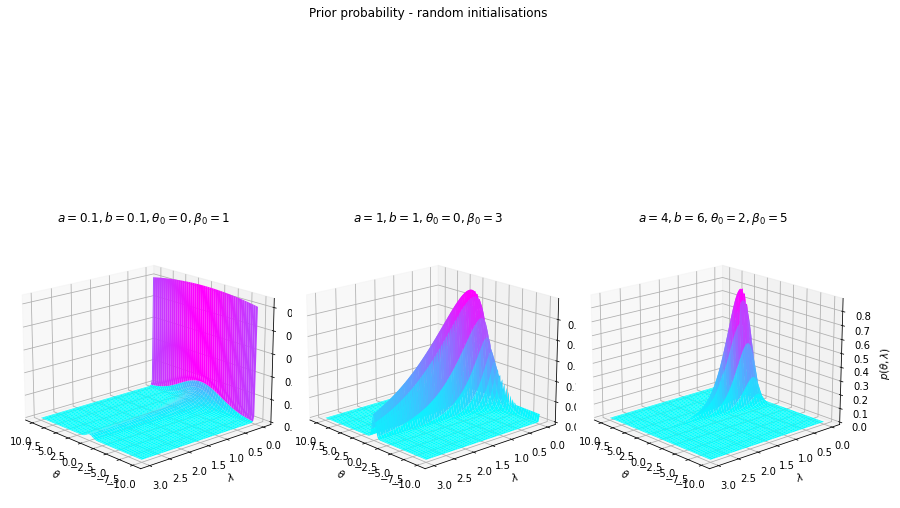

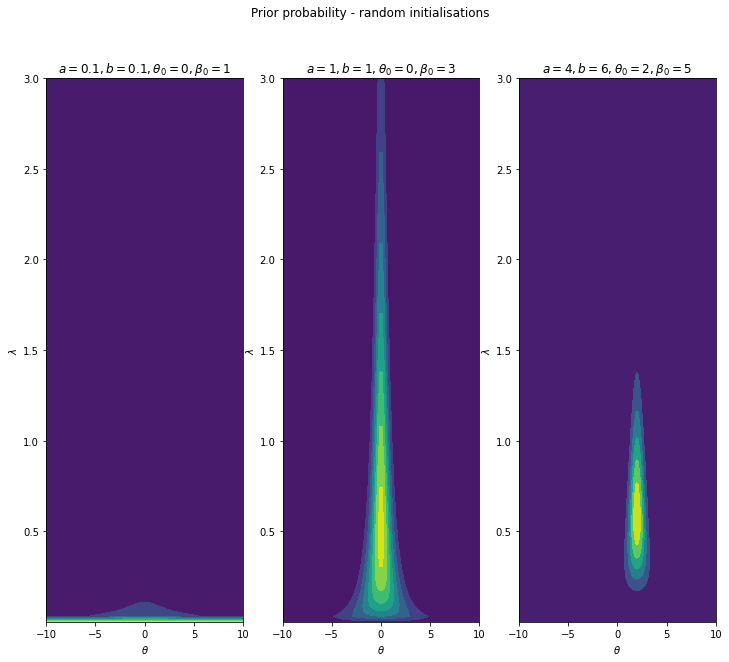

In [176]:
#a, b, theta, beta
param1 = [0.1, 0.1, 0, 1]
param2 = [1, 1, 0, 3]
param3 = [4, 6, 2, 5]

param_list = [param1, param2, param3]

prior_prob1 = normal_gamma(XY, 
                           param1, 
                           log_flag = True)

prior_prob2 = normal_gamma(XY, 
                           param2,
                           log_flag = True)

prior_prob3 = normal_gamma(XY, 
                           param3,
                           log_flag = True)


fig = plt.figure(figsize = (12, 10))
ax1 = fig.add_subplot(131, projection = '3d')
ax2 = fig.add_subplot(132, projection = '3d')
ax3 = fig.add_subplot(133, projection = '3d')

fig.suptitle("Prior probability - random initialisations")
ax1.plot_surface(X, Y, np.exp(prior_prob1.reshape(N, N)), cmap = plt.cm.cool)
ax2.plot_surface(X, Y, np.exp(prior_prob2.reshape(N, N)), cmap = plt.cm.cool)
ax3.plot_surface(X, Y, np.exp(prior_prob3.reshape(N, N)), cmap = plt.cm.cool)
ax3.view_init(elev = 18, azim = 138)
for cnt, axs in enumerate([ax1, ax2, ax3]):
    axs.set_xlabel(r"$\theta$")
    axs.set_ylabel(r"$\lambda$")
    axs.set_zlabel(r"$p(\theta, \lambda)$")
    axs.view_init(elev = 18, azim = 138)
    
    axs.set_title(r"$a = {}, b = {}, \theta_0 = {}, \beta_0 = {}$".format(*param_list[cnt]))
    
#plt.savefig("./images/fig1b_4.png")
fig.tight_layout()
plt.show()

fig = plt.figure(figsize = (12, 10))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

fig.suptitle("Prior probability - random initialisations")
ax1.contourf(X, Y, np.exp(prior_prob1.reshape(N, N)))
ax2.contourf(X, Y, np.exp(prior_prob2.reshape(N, N)))
ax3.contourf(X, Y, np.exp(prior_prob3.reshape(N, N)))

for cnt, axs in enumerate([ax1, ax2, ax3]):
    
    axs.set_xlabel(r"$\theta$")
    axs.set_ylabel(r"$\lambda$")
    #axs.set_zlabel(r"$p(\theta, \lambda)$")
    
    axs.set_title(r"$a = {}, b = {}, \theta_0 = {}, \beta_0 = {}$".format(*param_list[cnt]))
    
#plt.savefig("./images/fig1b_4.png")

plt.show()


### Q1k) Perform Bayesian inference to infer the parameters

#### Posterior parameter investigation

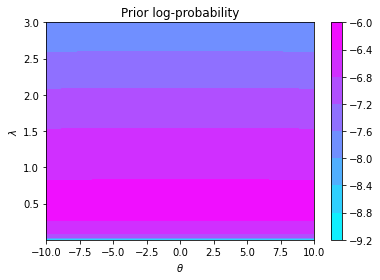

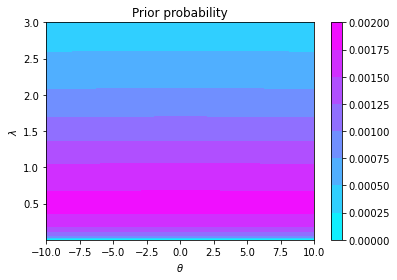

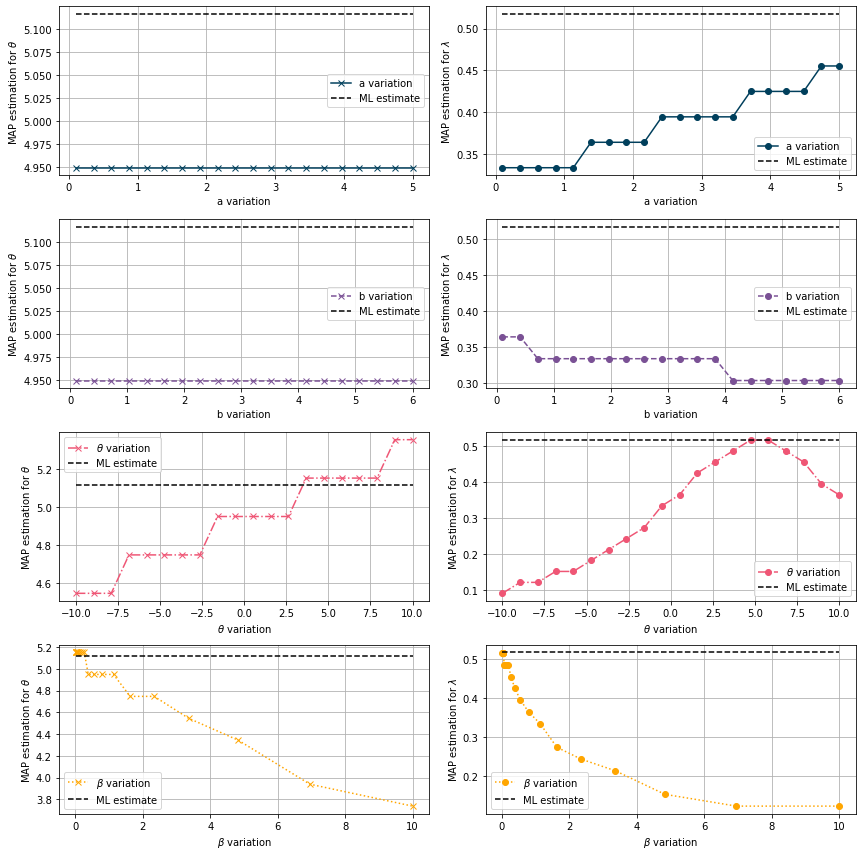

In [181]:
init_params_invest = [1, 1, 0, 0.00011]  #Produces a relatively flat prior

prior_prob = normal_gamma(XY, 
                           init_params_invest, 
                           log_flag = True)

plt.figure()
plt.title("Prior log-probability")
plt.contourf(X, Y, prior_prob.reshape(N, N), cmap = plt.cm.cool)
plt.colorbar()
plt.xlabel(r"$\theta$")
plt.ylabel(r"$\lambda$")
#plt.savefig("./images/fig1b_3.png")
plt.show()

plt.figure()
plt.title("Prior probability")
plt.contourf(X, Y, np.exp(prior_prob.reshape(N, N)), cmap = plt.cm.cool)
plt.colorbar()
plt.xlabel(r"$\theta$")
plt.ylabel(r"$\lambda$")
#plt.savefig("./images/fig1b_4.png")
plt.show()

N = 100
theta_range = np.linspace(-10, 10, N)
lambda_range = np.linspace(0.001, 3, N)

X, Y = np.meshgrid(theta_range, lambda_range)
XY = np.hstack((X.reshape(-1, 1), Y.reshape(-1, 1)))

Niter = 20
a_range = np.linspace(0.1, 5, Niter)
b_range = np.linspace(0.1, 6, Niter)
theta_range = np.linspace(-10, 10, Niter)
beta_range = np.logspace(-2, 1, Niter)
#Plot for variation

labels = ["a variation", "b variation", r"$\theta$ variation", r"$\beta$ variation"]
colors = ["#003f5c", "#7a5195", "#ef5675", "#ffa600"]
linestyles = ["-", "--", "-.", ":"]

fig, ax = plt.subplots(4, 2, figsize = (12, 12))
ax = ax.flatten()

for index_param, param_range in enumerate([a_range, b_range, theta_range, beta_range]):
    
    MAP_mean = []
    MAP_lambda = []
    
    init_params_invest = [1, 1, 0, 1]

    for param_iter in param_range:
        #Change the parameter
        init_params_invest[index_param] = param_iter
        
        #print(init_params_invest)

        #Update the parameters for the posterior
        post_params_invest = posterior_params(Q1_data, init_params_invest)

        #Obtain posterior MAP estimates
        posterior_prob_invest = normal_gamma(XY, 
                                              post_params_invest, 
                                              log_flag = True)

        max_index_invest = np.argmax(posterior_prob_invest)
        MAP_params_invest = XY[max_index_invest, :]
        #print("Grid-based MAP mean: {}".format(MAP_params[0]))
        #print("Grid-based MAP std deviation: {}\n".format(np.sqrt(1/MAP_params[1])))
        
        #Just store the grid parameters
        MAP_mean.append(MAP_params_invest[0])
        MAP_lambda.append(MAP_params_invest[1])
        
        """
        ##Numerical optimisation - very sensitive! You will need to set the initial parameters carefully
        x0 = [MAP_params_invest[0], MAP_params_invest[1]] #Assume that grid-based MAP parameters are suitable
        #print(x0)

        results_opt = sciopt.minimize(normal_gamma, 
                                      x0, 
                                      args = (post_params_invest, 
                                              True, 
                                              True)#Turn on the log-flag and the negative-flag
                                     ) 
        
        if np.abs(results_opt["x"][1] - x0[1]) > 10:
            
            #Just store the grid parameters
            MAP_mean.append(x0[0])
            MAP_lambda.append(x0[1])
            
        else:
            MAP_mean.append(results_opt["x"][0])
            MAP_lambda.append(results_opt["x"][1])
        """
    
    print("\n\n")
    
    ax[int(2 * index_param)].plot(param_range, MAP_mean, color = colors[index_param], linestyle = linestyles[index_param], marker = "x", label = labels[index_param])
    ax[int(2 * index_param + 1)].plot(param_range, MAP_lambda, color = colors[index_param], linestyle = linestyles[index_param], marker = "o", label = labels[index_param])
    
    ax[int(2 * index_param)].set_xlabel(labels[index_param])
    ax[int(2 * index_param + 1)].set_xlabel(labels[index_param])
    
    ax[int(2 * index_param)].set_ylabel(r"MAP estimation for $\theta$")
    ax[int(2 * index_param + 1)].set_ylabel(r"MAP estimation for $\lambda$")
    
    #Plot the ML estimate
    ax[int(2 * index_param)].plot([param_range[0], param_range[-1]], [mu_ML] * 2, "k--", label = "ML estimate")
    ax[int(2 * index_param + 1)].plot([param_range[0], param_range[-1]], [1/sigma_ML**2] * 2, "k--", label = "ML estimate")
    
    
    
for axs in ax:
    
    axs.grid()
    axs.legend()
    
fig.tight_layout()
plt.show()

#### Actual inference

In [ ]:
a = 1
b = 1
theta_mu = 0
beta = 0.1
init_params = (a, b, theta_mu, beta)#a, b, theta, beta


N = 100
theta_range = np.linspace(-10, 10, N)
lambda_range = np.linspace(0.001, 3, N)

X, Y = np.meshgrid(theta_range, lambda_range)
XY = np.hstack((X.reshape(-1, 1), Y.reshape(-1, 1)))

plt.figure()
plt.plot(theta_range, gaussian_likelihood(theta_range, theta_mu, 1/beta))
plt.xlabel(r"$\theta$")
plt.savefig("./images/fig1b_1.png")
plt.show()

plt.figure()
plt.plot(lambda_range, gamma_likelihood(lambda_range, a, b))
plt.ylabel(r"$\lambda$")
plt.savefig("./images/fig1b_2.png")
plt.show()

#Plot the prior
print("Initial parameters: {}\n".format(init_params))
prior_prob = normal_gamma(XY, 
                           init_params, 
                           log_flag = True)

plt.figure()
plt.title("Prior log-probability")
plt.contourf(X, Y, prior_prob.reshape(N, N), cmap = plt.cm.cool)
plt.colorbar()
plt.xlabel(r"$\theta$")
plt.ylabel(r"$\lambda$")
plt.savefig("./images/fig1b_3.png")
plt.show()

plt.figure()
plt.title("Prior probability")
plt.contourf(X, Y, np.exp(prior_prob.reshape(N, N)), cmap = plt.cm.cool)
plt.colorbar()
plt.xlabel(r"$\theta$")
plt.ylabel(r"$\lambda$")
plt.savefig("./images/fig1b_4.png")
plt.show()

#Update the parameters
post_params = posterior_params(Q1_data, init_params)
print("Posterior parameters: {}\n".format(post_params))

### Q1l) Calculate the MAP estimates of the unknown parameters

This can be done with a grid or with numerical optimisation

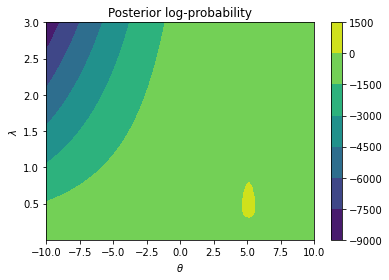

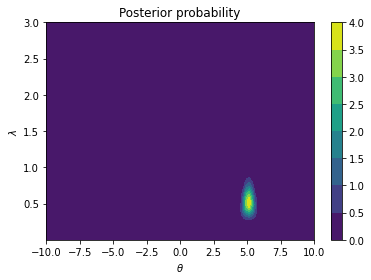

Grid-based MAP mean: 5.1515151515151505
Grid-based MAP std deviation: 1.3921423682644998

[5.116094896529196, 0.5171812503240467]
      fun: -1.3876116693019063
 hess_inv: array([[ 7.74422687e-02, -1.01399752e-06],
       [-1.01399752e-06,  2.05118345e-02]])
      jac: array([1.49011612e-08, 5.51342964e-07])
  message: 'Optimization terminated successfully.'
     nfev: 21
      nit: 4
     njev: 7
   status: 0
  success: True
        x: array([5.11607238, 0.51646909])

Optimisation-based MAP mean: 5.116072379441307
Optimisation-based MAP std deviation: 1.3914827701489338


In [142]:
#Calculate the MAP parameters

##Grid-based
posterior_prob = normal_gamma(XY, 
                              post_params, 
                              log_flag = True)

plt.figure()
plt.title("Posterior log-probability")
plt.contourf(X, Y, posterior_prob.reshape(N, N))
plt.xlabel(r"$\theta$")
plt.ylabel(r"$\lambda$")
plt.colorbar()
plt.show()

plt.figure()
plt.title("Posterior probability")
plt.contourf(X, Y, np.exp(posterior_prob.reshape(N, N)))
plt.xlabel(r"$\theta$")
plt.ylabel(r"$\lambda$")
plt.colorbar()
plt.show()

max_index = np.argmax(posterior_prob)
MAP_params = XY[max_index, :]
print("Grid-based MAP mean: {}".format(MAP_params[0]))
print("Grid-based MAP std deviation: {}\n".format(np.sqrt(1/MAP_params[1])))

##Numerical optimisation - very sensitive! You will need to set the initial parameters carefully
lambda_init = (1/sigma_ML)**2
x0 = [mu_ML, lambda_init] #Assume that ML parameters are suitable
#print(x0)

results_opt = sciopt.minimize(normal_gamma, 
                              x0, 
                              args = (post_params, 
                                      True, 
                                      True)#Turn on the log-flag and the negative-flag
                             ) 

print(results_opt)

mu_opt = results_opt['x'][0]
lambda_opt = results_opt['x'][1]
sigma_opt = np.sqrt(1 / lambda_opt)

print("\nOptimisation-based MAP mean: {}".format(mu_opt))
print("Optimisation-based MAP std deviation: {}".format(sigma_opt))

### Q1m) Plot the posterior distribution

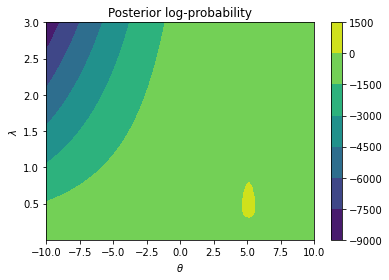

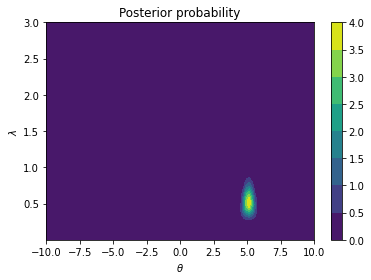

In [141]:
#Plot the posterior
posterior_prob = normal_gamma(XY, 
                              post_params, 
                              log_flag = True,
                              )

plt.figure()
plt.title("Posterior log-probability")
plt.contourf(X, Y, posterior_prob.reshape(N, N))
plt.xlabel(r"$\theta$")
plt.ylabel(r"$\lambda$")
plt.colorbar()
plt.show()

plt.figure()
plt.title("Posterior probability")
plt.contourf(X, Y, np.exp(posterior_prob.reshape(N, N)))
plt.xlabel(r"$\theta$")
plt.ylabel(r"$\lambda$")
plt.colorbar()
plt.show()

### Q1n) Plot $p(\theta \vert \mathbf{x})$ - The mean posterior marginal distribution

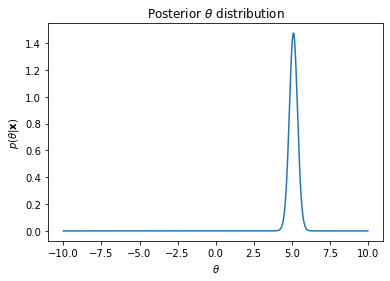

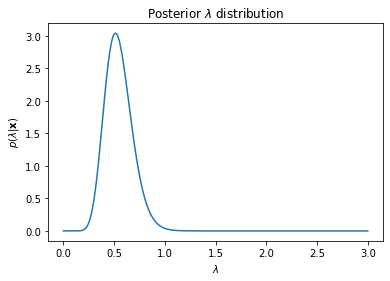

In [135]:
post_marginal_theta = posterior_theta(theta_range, 
                                      post_params, 
                                      log_flag = False)

post_marginal_lambda = posterior_lambda(lambda_range,
                                        post_params,
                                       log_flag = False)

plt.figure()
plt.title(r"Posterior $\theta$ distribution")
plt.plot(theta_range, post_marginal_theta)
plt.xlabel(r"$\theta$")
plt.ylabel(r"$p(\theta \vert\mathbf{x})$")
plt.show()

plt.figure()
plt.title(r"Posterior $\lambda$ distribution")
plt.plot(lambda_range, post_marginal_lambda)
plt.xlabel(r"$\lambda$")
plt.ylabel(r"$p(\lambda \vert\mathbf{x})$")
plt.show()

### Q1o) Calculate and compare the following two quantities: $p(θ \leq 4 \vert \mathbf{x})$ and $p(x \leq 4 \vert \mathbf{x})$. Briefly discuss the differences between these quantities and how they should be used in the inference process.

### Q1p) - not asked but was done: Plot the posterior predictive distribution

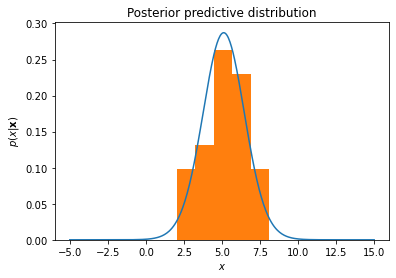

In [106]:
#Plot the posterior predictive distribution
x_range = np.linspace(-5, 15, N)
post_predict = posterior_predictive(x_range, post_params)
plt.figure()
plt.title("Posterior predictive distribution")
plt.plot(x_range, post_predict)
plt.hist(Q1_data, bins = 5, density = True)
plt.xlabel(r"$x$")
plt.ylabel(r"$p(x \vert \mathbf{x})$")
plt.show()

# Problem 2

## Load in the data

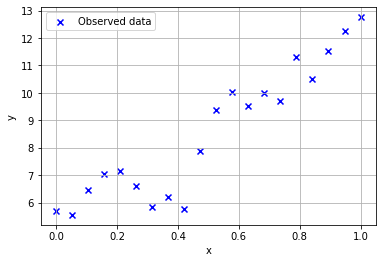

0.5


In [86]:
Q2_mat = io.loadmat("G:/My Drive/Engineering/PhD/2022/MIL780/Block 2/Assignment/a2_data2.mat")

Q2_x = Q2_mat["x"][0, :].reshape(-1, 1)
Q2_y = Q2_mat["y"][0, :].reshape(-1, 1)
Q2_std_noise = Q2_mat["std_of_noise"][0, 0]

plt.figure()
plt.scatter(Q2_x[:, 0], Q2_y[:, 0], color = "b", marker = "x", label = "Observed data")
plt.xlabel("x")
plt.ylabel("y")
plt.grid()
plt.legend()
plt.show()

print(Q2_std_noise)

In [92]:
def gaussian_likelihood(x, mu, sigma):
    p1 =1/(np.sqrt(2 * np.pi * sigma**2))
    p2 = np.exp(- 1/(2 * sigma**2) * (x - mu)**2)
    return  p1 * p2

def gaussian_log_likelihood(x, mu, sigma):
    p1 = - 1/2 * np.log(2 * np.pi)
    p2 = - 1/2 * np.log(sigma**2)
    p3 = - 1/(2 * sigma**2) * (x - mu)**2
    return p1 + p2 + p3

def feature_transform(X, K):
    
    return X**np.arange(K + 1)

def f_x(X, omega):
    
    K = omega.shape[0] - 1 #Index starts at zero
    
    Xtransform = feature_transform(X, K)
    
    return np.dot(Xtransform, omega)

def log_likelihood_function(X, t, omega, sigma):
    
    N = X.shape[0]
    
    term1 = -N/2 * np.log(2 * np.pi)
    term2 = -N/2 * np.log(sigma**2)
    
    t_pred = f_x(X, omega)
    
    term3 = -1/(2 * sigma**2) * np.sum((t - t_pred)**2, axis = 0)
    
    log_likelihood = term1 + term2 + term3
    
    return log_likelihood

#Step 1 - define the Phi matrix function
def Phi_func(X, K):
    
    return X**np.arange(K + 1)

def maximum_likelihood_solution(X, t, K, sigma = None, biased = True, verbose = False):

    #calculate Phi
    Phi = Phi_func(X, K)

    #calculate ATA
    ATA = np.dot(Phi.T, Phi)

    #Calculate ATb
    ATb = np.dot(Phi.T, t)

    #Check shapes are K + 1 x K + 1 and K + 1 x 1
    #print(ATA.shape, ATb.shape)

    #Calculate Omega
    omega_ML = np.linalg.solve(ATA, ATb)
    
    #Calculate sigma
    if sigma is None:
        
        t_pred = f_x(X, omega_ML)

        if biased:
            divisor = X.shape[0]

        else:
            divisor = X.shape[0] - K - 1

        sigma_ML = np.sqrt(1/divisor * np.sum((t_pred - t)**2, axis = 0))
    
    else:
        sigma_ML = sigma

    #Calculate the log-likelihood:
    LL = log_likelihood_function(X, t, omega_ML, sigma_ML)[0]

    #Calculate the covariance
    cov_ML = (sigma_ML**2) * np.linalg.inv(ATA)
    
    if verbose: 
        print("For a {}th order polynomial:".format(K))
        print("\nOptimal weights:\n{}\n".format(omega_ML))
        print("Optimal sigma:\n{}\n".format(sigma_ML))
        print("Optimal model log-likelihood:\n{}\n".format(LL))
    
    return omega_ML, cov_ML, sigma_ML, LL

def posterior_solution(X, t, K, alpha, beta, sigma = None, verbose = False):
    
    #calculate Phi
    Phi = Phi_func(X, K)

    #calculate ATA
    ATA = np.dot(Phi.T, Phi)
    
    #Adjust ATA
    ATA_adjust = ATA + alpha / beta * np.eye(K + 1)
    
    #Calculate ATb
    ATb = np.dot(Phi.T, t)
    
    #Calculate Omega MAP estimate
    omega_MAP = np.linalg.solve(ATA_adjust, ATb)
    
    sigma_MAP = None
    cov_MAP = np.linalg.inv(beta * ATA + alpha * np.eye(K + 1))
    
    if verbose: 
        print("For a {}th order polynomial:".format(K))
        print("\nOptimal posterior distribution mean:\n{}\n".format(omega_MAP))
    
    return omega_MAP, cov_MAP, sigma_MAP

def posterior_predictive(X, omega_MAP, cov_MAP, alpha, beta, test_method = True):
    
    N = X.shape[0]
    
    K = omega_MAP.shape[0] - 1
    
    #Calculate posterior predictive mean
    mean_x = f_x(X, omega_MAP)[:, 0]
    
    #Calculate Phi
    Phi = Phi_func(X, K)
    
    #Calculate posterior predictive covariance
    
    if test_method: #vectorised form of x^T A x
        cov_x = 1/beta + np.sum(np.dot(Phi, cov_MAP) * Phi, axis = 1).reshape(-1)
    
    else: #unvectorised form
        cov_x = np.zeros(N)
        
        for i in range(N):
            
            Phi = Phi_func(X[[i], :], K).T
            
            cov_x[i] = 1/beta + np.dot(Phi.T, np.dot(cov_MAP, Phi))
            
    return mean_x, cov_x

def posterior_predictive_sample_ll(X, t, omega_MAP, cov_MAP, alpha, beta):
    
    N = X.shape[0]
    
    mean_x, cov_x = posterior_predictive(X, 
                                         omega_MAP, 
                                         cov_MAP, 
                                         alpha, 
                                         beta, 
                                         test_method = True)
    
    LL = np.zeros(N)
    
    for i in range(N):
        LL[i] = gaussian_log_likelihood(t[i, 0], mean_x[i], np.sqrt(cov_x[i]))
        
    return LL
        
    


## Q2) Sample the prior and plot the data

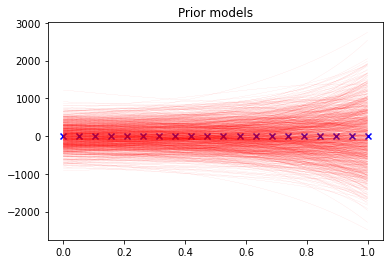

In [89]:
K = 5
alpha = 1e-5
beta = 1/(Q2_std_noise**2)
          
#Prior sampling
prior_dist = scistats.multivariate_normal(mean = np.zeros(K + 1), cov = 1/alpha * np.eye(K + 1))
prior_samples = prior_dist.rvs(1000)

#Define function domain of interest
Xtest = np.linspace(np.min(Q2_x), np.max(Q2_x), 1000).reshape(-1, 1)

plt.figure()
plt.title("Prior models")
for i in range(prior_samples.shape[0]):
    
    t_pred = f_x(Xtest, prior_samples[i, :].reshape(-1, 1))
    
    plt.plot(Xtest[:, 0], t_pred[:, 0], "r--", linewidth = 0.05)
plt.scatter(Q2_x[:, 0], Q2_y[:, 0], color = "b", marker = "x", label = "Observed data")
plt.show()

## Q2a) Report the form of the posterior and provide its parameters for $\alpha = 1e^{-5}$.

ML mean: 
[[   5.28734118]
 [  30.3441581 ]
 [-222.73828169]
 [ 630.08857317]
 [-706.51125811]
 [ 276.571347  ]]

ML covariance: 
[[ 2.11699605e-01 -3.47814526e+00  1.77958375e+01 -3.87513167e+01
   3.76668898e+01 -1.34570598e+01]
 [-3.47814526e+00  1.03027453e+02 -6.52542702e+02  1.59058003e+03
  -1.65829177e+03  6.21463292e+02]
 [ 1.77958375e+01 -6.52542702e+02  4.51022467e+03 -1.15705452e+04
   1.24805509e+04 -4.79251086e+03]
 [-3.87513167e+01  1.59058003e+03 -1.15705452e+04  3.06674788e+04
  -3.38506597e+04  1.32245517e+04]
 [ 3.76668898e+01 -1.65829177e+03  1.24805509e+04 -3.38506597e+04
   3.80054319e+04 -1.50443167e+04]
 [-1.34570598e+01  6.21463292e+02 -4.79251086e+03  1.32245517e+04
  -1.50443167e+04  6.01772667e+03]]

ML sigma^2: 0.5

ML Log-likelihood: -19.421442661841198

Posterior mean: 
[[   5.61643951]
 [  16.38205614]
 [-119.38955151]
 [ 352.77045487]
 [-397.52975456]
 [ 154.9652081 ]]

Posterior covariance: 
[[ 1.92312895e-01 -2.66586359e+00  1.18168347e+01 -2.27658388

<Figure size 432x288 with 0 Axes>

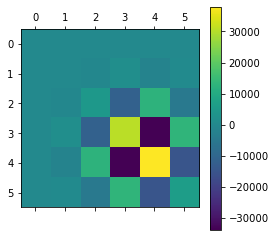

<Figure size 432x288 with 0 Axes>

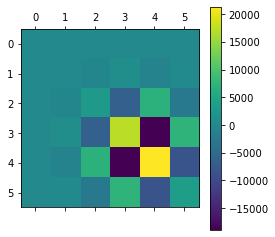

In [93]:
K = 5
alpha = 1e-5
beta = 1/(Q2_std_noise**2)

#Maximum likelihood solution
ML_solution = maximum_likelihood_solution(Q2_x, 
                                        Q2_y, 
                                        K,
                                        sigma = Q2_std_noise,
                                        biased = True, 
                                        verbose = False)

omega_ML, cov_ML, sigma_ML, ML_LL = ML_solution

print("ML mean: \n{}\n".format(omega_ML))
print("ML covariance: \n{}\n".format(cov_ML))
print("ML sigma^2: {}\n".format(sigma_ML))
print("ML Log-likelihood: {}\n".format(ML_LL))

#MAP solution
MAP_solution = posterior_solution(Q2_x, 
                                   Q2_y, 
                                   K,
                                   alpha,
                                   beta,
                                   Q2_std_noise,
                                   verbose = False)

omega_MAP, cov_MAP, sigma_MAP = MAP_solution

MAP_LL = posterior_predictive_sample_ll(Q2_x.reshape(-1, 1),
                                         Q2_y.reshape(-1, 1), 
                                         omega_MAP, 
                                         cov_MAP, 
                                         alpha, 
                                         beta)

print("Posterior mean: \n{}\n".format(omega_MAP))
print("Posterior covariance: \n{}\n".format(cov_MAP))
print("Posterior predictive log-likelihood: {}\n".format(np.sum(MAP_LL)))

plt.figure()
plt.matshow(cov_ML)
plt.colorbar()
plt.show()

plt.figure()
plt.matshow(cov_MAP)
plt.colorbar()
plt.show()

## Q2b) Draw samples from the posterior and plot the functions associated with the samples on the available data

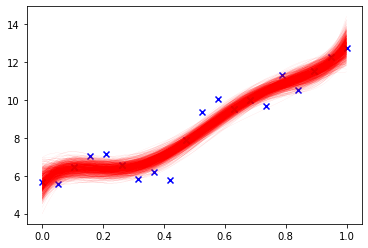

In [76]:
K = 5
alpha = 1e-5
beta = 1/(Q2_std_noise**2)

#Posterior sampling
posterior_dist = scistats.multivariate_normal(mean = omega_MAP[:, 0], cov = cov_MAP)
posterior_samples = posterior_dist.rvs(1000)

#Define function domain of interest
Xtest = np.linspace(np.min(Q2_x), np.max(Q2_x), 1000).reshape(-1, 1)

plt.figure()

for i in range(posterior_samples.shape[0]):
    
    t_pred = f_x(Xtest, posterior_samples[i, :].reshape(-1, 1))
    
    plt.plot(Xtest[:, 0], t_pred[:, 0], "r--", linewidth = 0.05)
plt.scatter(Q2_x[:, 0], Q2_y[:, 0], color = "b", marker = "x", label = "Observed data")
plt.show()

## Q2c) Superimpose the posterior predictive mean and two standard deviations of the posterior predictive on the available data

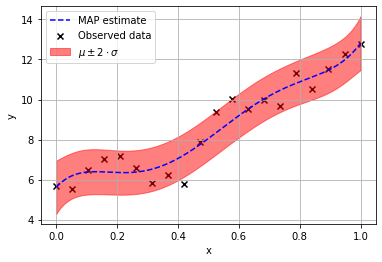

In [96]:
K = 5
alpha = 1e-5
beta = 1/(Q2_std_noise**2)

#Posterior_predictive
mean_post_pred, cov_post_pred = posterior_predictive(Xtest,
                                      omega_MAP,
                                      cov_MAP,
                                      alpha,
                                      beta,
                                      test_method = True)

plt.figure()
plt.scatter(Q2_x[:, 0], Q2_y[:, 0], color = "k", marker = "x", label = "Observed data")
plt.plot(Xtest[:, 0], mean_post_pred, "b--", label = "MAP estimate")

plt.fill_between(Xtest[:, 0], 
                 mean_post_pred - 2 * np.sqrt(cov_post_pred), 
                 mean_post_pred + 2 * np.sqrt(cov_post_pred), 
                 alpha = 0.5, 
                 color = "r", 
                 label = r"$\mu \pm 2 \cdot \sigma$")

plt.xlabel("x")
plt.ylabel("y")
plt.grid()
plt.legend()
plt.show()

## Q2d) Investigate the influence of α on the performance of the model

- Incrementally increase the order of the polynomial from 1 to 10.
- Find the maximum likelihood estimate of the model.
- Find the maximum a posteriori (MAP) estimate of the model for different αs.
- Identify, motivate and use model performance metrics (e.g. posterior prediction error).

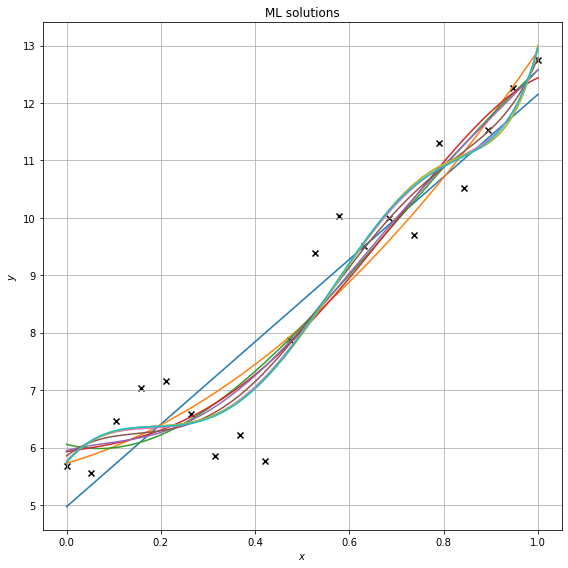

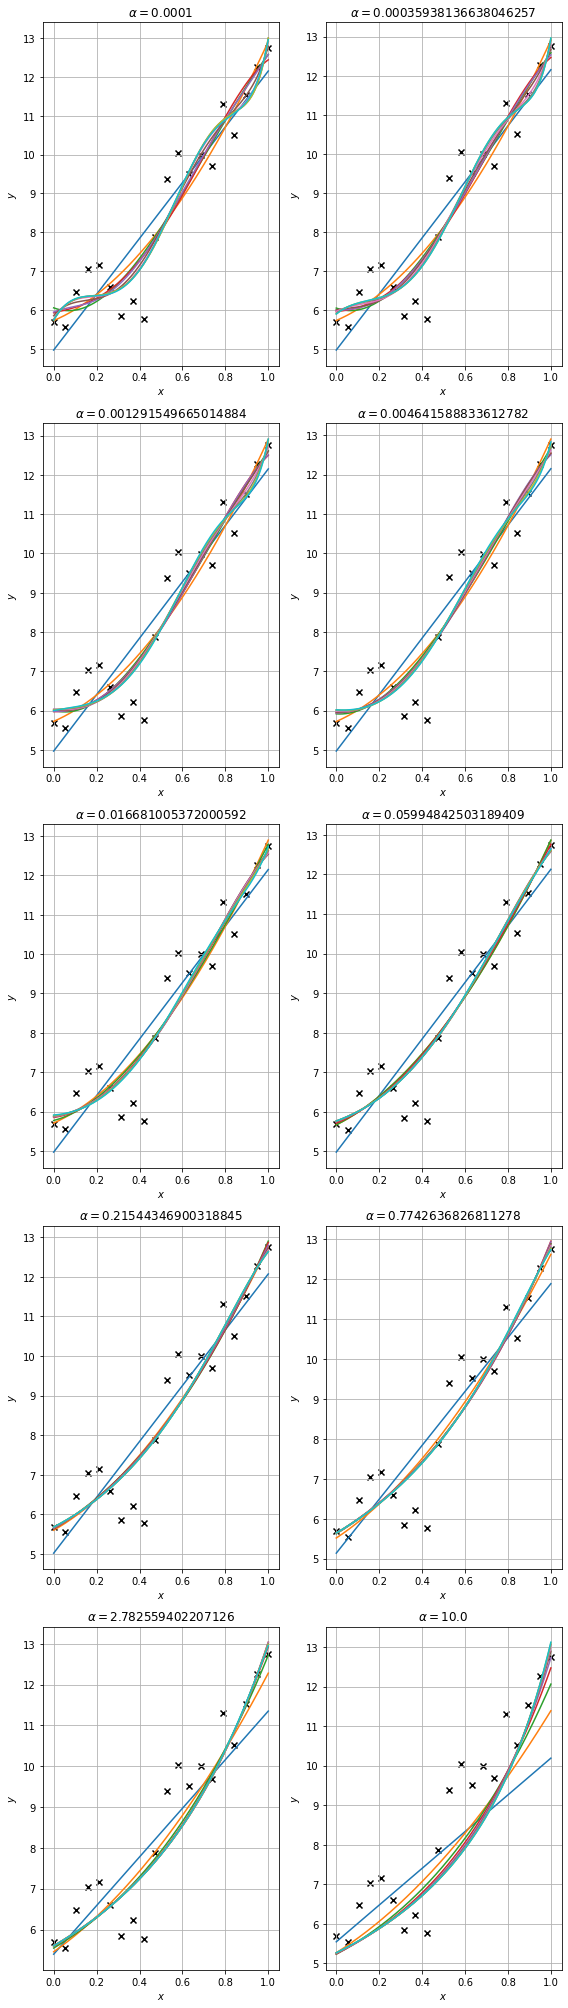

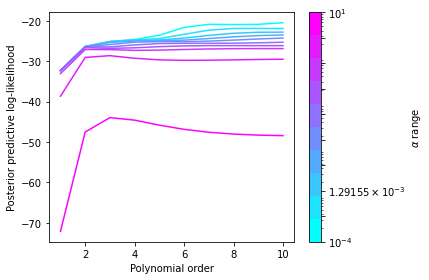

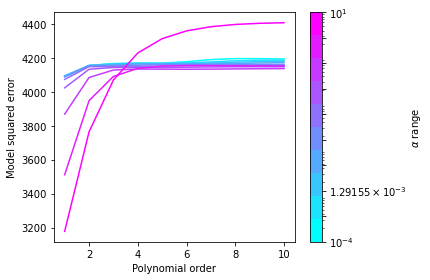

In [121]:
alpha_range = np.logspace(-4, 1, 10)
k_range = range(1, 11, 1)

alpha_MAP_lines = []
alpha_MAP_LL = np.zeros((len(alpha_range), len(k_range)))
alpha_MAP_error = np.zeros_like(alpha_MAP_LL)

colors = plt.cm.cool(np.arange(len(alpha_range)) / len(alpha_range))

for cnt_alpha, alpha in enumerate(alpha_range):
    alpha_ML_lines = [] #Place this here to ensure because ML plots do not change
    ML_lines = []
    post_pred_lines = []
    post_pred_LL = []
    post_pred_error = []
    

    for cnt_k, K in enumerate(k_range):

        #Maximum likelihood solution
        ML_solution = maximum_likelihood_solution(Q2_x, 
                                                Q2_y, 
                                                K,
                                                sigma = Q2_std_noise,
                                                biased = True, 
                                                verbose = False)

        omega_ML, cov_ML, sigma_ML, LL = ML_solution

        #print("K = {}".format(K))
        #print("ML mean: \n{}\n".format(omega_ML))
        #print("ML covariance: \n{}\n".format(cov_ML))
        #print("ML sigma^2: {}\n".format(sigma_ML))
        #print("ML Log-likelihood: {}\n".format(LL))

        #MAP solution
        MAP_solution = posterior_solution(Q2_x, 
                                           Q2_y, 
                                           K,
                                           alpha,
                                           beta,
                                           Q2_std_noise,
                                           verbose = False)

        omega_MAP, cov_MAP, sigma_MAP = MAP_solution

        #Determine the posterior predictive distribution
        mean_post_pred, cov_post_pred = posterior_predictive(Xtest,
                                          omega_MAP,
                                          cov_MAP,
                                          alpha,
                                          beta,
                                          test_method = True)
        
        MAP_LL = posterior_predictive_sample_ll(Q2_x.reshape(-1, 1),
                                         Q2_y.reshape(-1, 1), 
                                         omega_MAP, 
                                         cov_MAP, 
                                         alpha, 
                                         beta)
        
        #Calculate the model error
        t_post_pred, _ = posterior_predictive(Q2_x.reshape(-1, 1),
                                          omega_MAP,
                                          cov_MAP,
                                          alpha,
                                          beta,
                                          test_method = True)

        #Store in lists
        ML_lines.append(f_x(Xtest, omega_ML)[:, 0])
        post_pred_lines.append(mean_post_pred)
        
        alpha_MAP_LL[cnt_alpha, cnt_k] = np.sum(MAP_LL)
        alpha_MAP_error[cnt_alpha, cnt_k] = np.sum((Q2_y - t_post_pred)**2)
    
    #Store in global lists
    alpha_ML_lines.append(ML_lines)
    alpha_MAP_lines.append(post_pred_lines)

############################
#ML Plots
############################
fig, ax = plt.subplots(len(alpha_ML_lines), 1, figsize = (8, 8))

for i in range(0, len(alpha_ML_lines), 1):
    for j in range(len(alpha_ML_lines[i])):
        
        ax.plot(Xtest[:, 0], alpha_MAP_lines[i][j])
        
ax.set_title(r"ML solutions")
ax.scatter(Q2_x, Q2_y, marker = "x", color = "k")
ax.grid()
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")

fig.tight_layout()
plt.show()

############################
#MAP Plots
############################
fig, ax = plt.subplots(len(alpha_range) // 2, 2, figsize = (8, 28))
ax = ax.flatten()

for i in range(0, len(alpha_range), 2):
    for j in range(len(alpha_MAP_lines[i])):
        
        
        
        ax[int(i)].plot(Xtest[:, 0], alpha_MAP_lines[i][j])
        ax[int(i + 1)].plot(Xtest[:, 0], alpha_MAP_lines[i + 1][j])
        
        ax[i].set_title(r"$\alpha = {}$".format(alpha_range[i]))
        ax[i + 1].set_title(r"$\alpha = {}$".format(alpha_range[i + 1]))
        
for axs in ax:
    axs.scatter(Q2_x, Q2_y, marker = "x", color = "k")
    axs.grid()
    axs.set_xlabel(r"$x$")
    axs.set_ylabel(r"$y$")

fig.tight_layout()
plt.show()

fig, ax = plt.subplots()
# Make dummie mappable
cmap = mpl.cm.get_cmap('cool', len(alpha_range))
c = alpha_range
dummie_cax = ax.scatter(c, c, c=c, norm = LogNorm(), cmap=cmap)
# Clear axis
ax.cla()
for i in range(len(alpha_range)):
    
    ax.plot(k_range, alpha_MAP_LL[i, :], color = cmap(i))

ax.set_xlabel("Polynomial order")
ax.set_ylabel("Posterior predictive log-likelihood")

cbar = fig.colorbar(dummie_cax, ticks=c)
cbar.set_label(r"$\alpha$ range")
fig.tight_layout()
plt.show()
########################################
fig, ax = plt.subplots()
# Make dummie mappable
cmap = mpl.cm.get_cmap('cool', len(alpha_range))
c = alpha_range
dummie_cax = ax.scatter(c, c, c=c, norm = LogNorm(), cmap=cmap)
# Clear axis
ax.cla()
for i in range(len(alpha_range)):
    
    ax.plot(k_range, alpha_MAP_error[i, :], color = cmap(i))

ax.set_xlabel("Polynomial order")
ax.set_ylabel("Model squared error")  

cbar = fig.colorbar(dummie_cax, ticks=c)
cbar.set_label(r"$\alpha$ range")
fig.tight_layout()
plt.show()

## Q2e) Briefly discuss the meaning behind the prior predictive distribution, the functions generated by sampling from the posterior distribution and the posterior predictive distribution. For example, how should one use and interpret the distributions?

Nothing to do here, write in report

## Q2f) Calculate the probability that $P(w_1 > 8)$, $P(w_1 > 8 \vert x, y)$ and $P(y > 8 \vert x = 0.5, x, y)$. Discuss how these values should be interpreted.

## Q2g) How can the model evidence be used to select the model order? Use the model evidence to select the model order for this problem.

## Q2h) Discuss how sparsity can be implemented and used to identify the necessary model complexity to model the data. How does this differ from the previous model selection procedure?